# ACS Takehome Assignment (4 Tasks)

Two ONNX files (`fashion_mnist_static.onnx` and `fashion_mnist_dynamic.onnx`) are provided. The goal of this takehome assignment is to modify one of the provided ONNX graphs (`fashion_mnist_dynamic.onnx`) so it is same as the other provided ONNX graph (`fashion_mnist_static.onnx`). Then, build a quantized (FP16) TensorRT engine using the modified ONNX graph. The ONNX files are exported from a simple PyTorch CNN Model that was trained on the Fashion MNIST dataset (https://github.com/zalandoresearch/fashion-mnist).

`fashion_mnist_static.onnx` was exported via PyTorch assuming a batch size of 1. The command that was used to export the model is:

```
x = torch.randn(1, 1, 28, 28).to(device)
torch.onnx.export(
    model,
    x,
    fashion_mnist_static.onnx,
    input_names=["input"],
    output_names=["output"],
)
```

`fashion_mnist_dynamic.onnx` was exported via PyTorch assuming a dynamic batch size. The command that was used to export the model is:

```
x = torch.randn(1, 1, 28, 28).to(device)
torch.onnx.export(
    model,
    x,
    fashion_mnist_dynamic.onnx,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
```

Netron is a very nice GUI tool to help visualize deep learning models (like those ONNX files). https://netron.app/

Visualization of `fashion_mnist_static.onnx` graph using Netron. The only difference between `fashion_mnist_static.onnx` and `fashion_mnist_dynamic.onnx` is the input & output batch size. In `fashion_mnist_static.onnx`, the input size is `[1, 1, 28, 28]` and the output size is `[1, 10]` as shown below. In `fashion_mnist_dynamic.onnx`, the input size is `[batch_size, 1, 28, 28]` and the output size is `[batch_size, 10]`.
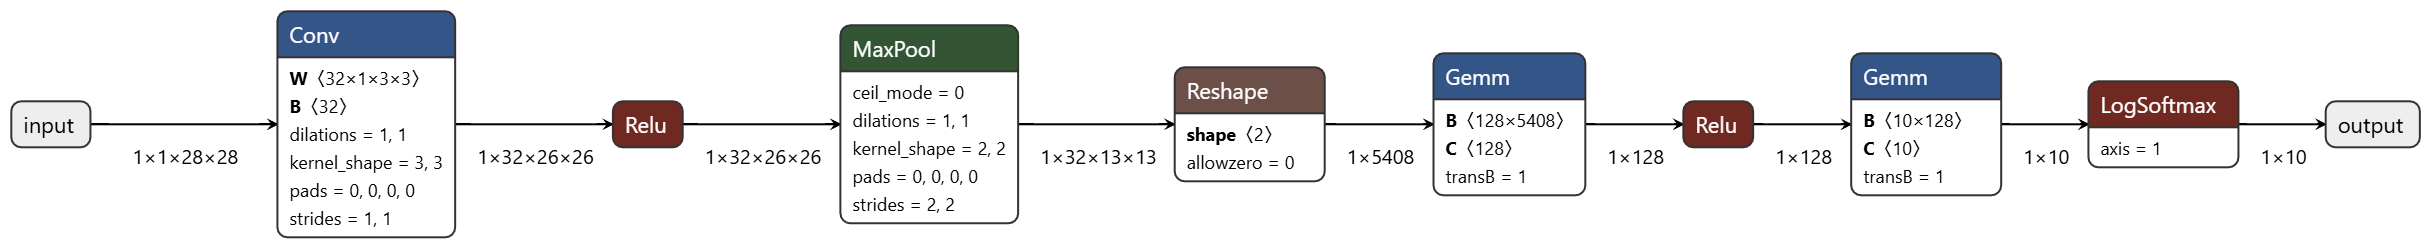

# General Set Up (Installing ONNX and TensorRT)

### This notebook was tested on
- Python Version: 3.11.11
- PyTorch Version: 2.5.1
- Cuda Version: 12.5
- TensorRT version: 10.8.0.43

In [ ]:
import torch
assert torch.cuda.is_available(), "You will need to use GPU for this assignment! (Change your runtime type in Google Colab)"
!nvidia-smi

Wed Feb 26 19:59:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### NOTE: Installing tensorRT could take a while (~10mins-20mins)

In [ ]:
!apt-get update
!apt-get install -y libnvinfer8 libnvinfer-dev libnvinfer-plugin8 python3-libnvinfer

In [ ]:
!pip install tensorrt cuda-python onnx onnxruntime onnxruntime-gpu onnx-graphsurgeon>=0.3.20

In [ ]:
import tensorrt as trt
assert trt.Builder(trt.Logger()), "TensorRT was not installed correclty, https://docs.nvidia.com/deeplearning/tensorrt/latest/installing-tensorrt/installing.html for more info"

# Generate a set of test images

In [ ]:
import time
import random
random.seed(42)

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

import onnx
import onnxruntime as ort
import onnx_graphsurgeon as gs
import tensorrt as trt
import ctypes
from cuda import cuda, cudart

# Grabbng 5 test images
fashion_labels = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

eval_images = [test_dataset[i] for i in range(5)] # [image, label]

# Task 1:

Use `ONNX GraphSurgeon` to modify `fashion_mnist_dynamic.onnx` by changing the input and output batch size from dynamic to static (set them to 1). The resulting graph should be identical to `fashion_mnist_static.onnx`.
1. Load the ONNX graph into onnx_graphsurgeon using: https://docs.nvidia.com/deeplearning/tensorrt/onnx-graphsurgeon/docs/importers/toc.html
2. Access the input and output of the ONNX graph and change input shape from `[batch_size, 1, 28, 28]` to `[1, 1, 28, 28]` and output shape from `[batch_size, 10]` to `[1, 10]` so it becomes the same as `fashion_mnist_static.onnx`: https://docs.nvidia.com/deeplearning/tensorrt/onnx-graphsurgeon/docs/ir/graph.html (the dimension name is batch_size).
3. Save the modified graph.

Netron is a very nice GUI tool to help visualize deep learning models (like those ONNX files). https://netron.app/

In [ ]:
# code goes here

# Task 2:

Build a FP16 TensorRT engine using the modified ONNX graph from Task 1. You will be using this engine for inference in Task 3.
  - This example from Nvidia should help: https://github.com/NVIDIA/TensorRT/tree/release/10.8/samples/python/introductory_parser_samples
  - Should be nearly the same, just swapping out `ResNet50.onnx` with your modified ONNX graph.
  - To build the quantized FP16 engine, use the appropriate builder flag: https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/BuilderConfig.html#tensorrt.BuilderFlag and the flag can be set with build configs: https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/BuilderConfig.html#tensorrt.IBuilderConfig.set_flag



Note: Building a TensorRT engine using Nvidia's sample code will fail for dynamic shapes. There are two possible solutions: use an optimization profile to build a dynamic engine or convert the dynamic batch size into static/fixed batch size. **Task 1 was the latter option**. More on using `OptimizationProfiles` at the end.

In [ ]:
# code goes here

# Task 3:

Run inference using the modified ONNX file and the TensorRT engine you built in Task 2.
  - Use `ONNXruntime` to run inference using an ONNX graph: https://onnxruntime.ai/docs/api/python/api_summary.html#load-and-run-a-model (`CPUExecutionProvider` is fine, no need for CUDA)
  - Create an execution context from the TensorRT engine to perform inference.
      - https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/ExecutionContext.html#tensorrt.IExecutionContext
      - https://github.com/NVIDIA/TensorRT/blob/release/10.8/samples/python/common_runtime.py#L163
      - https://github.com/NVIDIA/TensorRT/tree/release/10.8/samples/python/introductory_parser_samples
  - Display the image, ground truth label, predicted label using ONNX runtime, predicted label using TensorRT runtime, and their inference times (`time.time()` is good enough for this).
  - Can be done in a loop, inferencing one image at a time.
  - Both engine should produce the same prediction but inference time will vary.
  - Feel free to make modifications to any of the code in the cell below, but just make sure you are inferencing using ONNX runtime and the TensorRT engine you built prior on the test images `eval_images`.

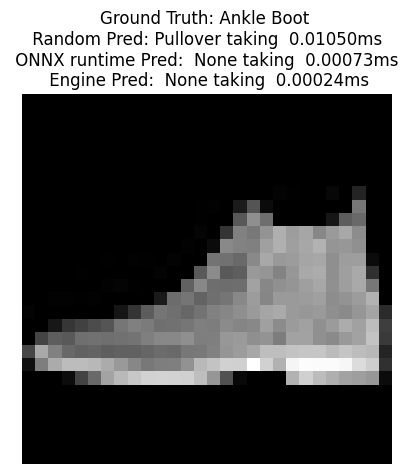

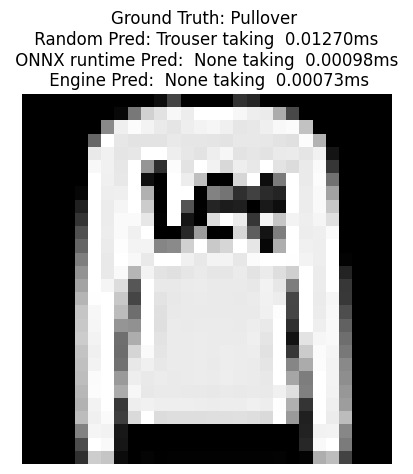

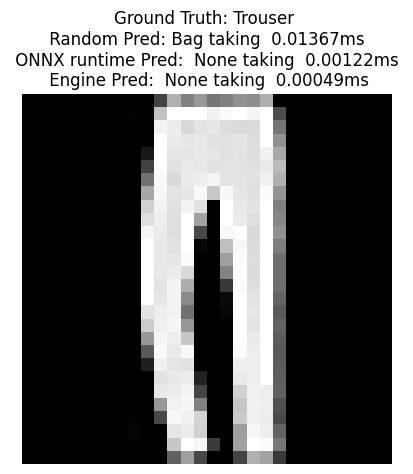

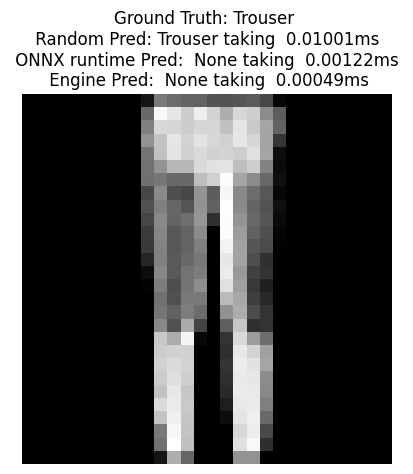

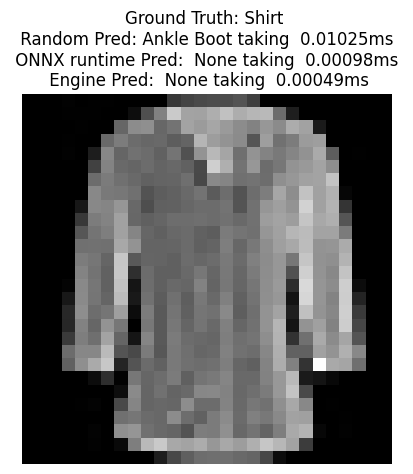

In [ ]:
for eval_image, eval_label in eval_images:

  # Inference using random selection
  start_time_ms = time.time() * 1000
  random_pred_label = random.choice(fashion_labels)
  rs_inference_time = time.time() * 1000 - start_time_ms

  # Inference using ONNX runtime
  start_time_ms = time.time() * 1000
  ONNX_runtime_pred_label = None # code goes here
  ONNX_runtime_inference_time = time.time() * 1000 - start_time_ms

  # Inference using TensorRT engine
  start_time_ms = time.time() * 1000
  engine_pred_label = None # code goes here
  engine_inference_time = time.time() * 1000 - start_time_ms

  # Show the image
  plt.imshow(eval_image.squeeze(0), cmap="gray")
  plt.title(f"Ground Truth: {fashion_labels[eval_label]} \n Random Pred: {random_pred_label} taking {rs_inference_time: .5f}ms \n ONNX runtime Pred:  {ONNX_runtime_pred_label} taking {ONNX_runtime_inference_time: .5f}ms \n Engine Pred:  {engine_pred_label} taking {engine_inference_time: .5f}ms")
  plt.axis("off")
  plt.show()

# Task 4:

Documentation of the process so that someone without TensorRT knowledge can follow through/understand/recreate.
  - No code needed, just 1-2 paragraphs here and proper comments in your code.

...

# Regarding TensorRT Engine with Dynamic Inputs

The TensorRT engine built will only work with a specific input size (static). To build an engine that accepts dynamic shapes, you will need to provide an `OptimizationProfile` during the build process.


If interested, here are some useful resources on it:
- Nvidia TensorRT Documentaion on Working with Dynamic Shapes: https://docs.nvidia.com/deeplearning/tensorrt/latest/inference-library/work-dynamic-shapes.html
- Optimization Profile documentation: https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/OptimizationProfile.html